[0.63, 0.51, 0.4666666666666667, 0.54, 0.45]
[588.1776548545222, 631.2809392837818, 785.0159138565696, 1061.3131276815238, 1375.6483454963825]


Text(0, 0.5, 'Accuracy')

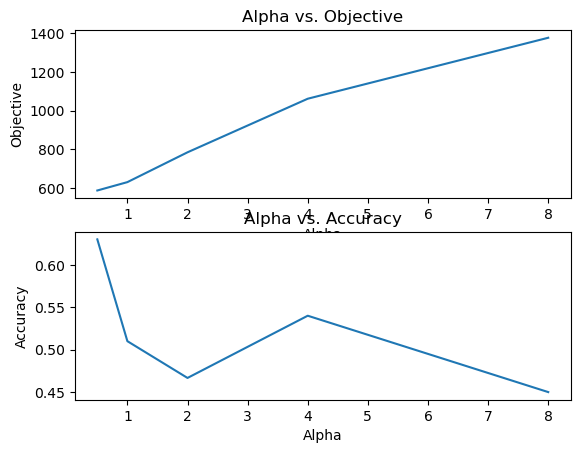

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

mu_1 = np.array([-1,-1])
mu_2 = np.array([1,-1])
mu_3 = np.array([0,1])
cov_1 = np.array([[2,0.5],[0.5,1]])
cov_2 = np.array([[1,-0.5],[-0.5,2]])
cov_3 = np.array([[1,0],[0,2]])
alpha_arr = np.array([0.5,1,2,4,8])
data_list = []
means_list = []
labels_list = []
objective_list = []
accuracy_list = []

#Generate data
for i in range(len(alpha_arr)):
    alpha = alpha_arr[i]
    data_1 = np.random.multivariate_normal(mu_1, alpha * cov_1, 100)
    data_2 = np.random.multivariate_normal(mu_2, alpha * cov_2, 100)
    data_3 = np.random.multivariate_normal(mu_3, alpha * cov_3, 100)
    data = np.vstack((data_1, data_2, data_3))
    data_list.append(data)

def calc_min_distance(point, means, num_means):
    distances = np.zeros(num_means)
    for i in range(num_means):
        distances[i] = np.linalg.norm(point-means[i])
        
    return (np.min(distances), np.argmin(distances)+1)

def calc_new_means(points, labels, num_means):
    sums_list = np.zeros((num_means,2))
    totals_list = np.zeros(num_means)
    for i in range(len(labels)):
        label = int(labels[i])
        sums_list[label-1] += points[label-1]
        totals_list[label-1] += 1
        
    means = np.zeros((num_means,2))
    for i in range(num_means):
        means[i] = sums_list[i] / totals_list[i]
        
    return means

#Compute means with k++ strategy
for i in range(len(alpha_arr)):
    data = data_list[i]
    means = np.zeros((3,2))
    
    #Select first mean randomly from points
    first_mean = data[np.random.randint(300)]
    means[0] = first_mean
    
    #Select remaining means using k++ strategy
    for j in range(2):
        distances = np.zeros(len(data))
        for k in range(len(data)):
            distances[k] = calc_min_distance(data[k], means, 1 + j)[0]
            
        probabilities = distances / np.sum(distances)
        next_mean_idx = np.random.choice(len(distances), p=probabilities)
        means[j+1] = data[next_mean_idx]
        
    means_list.append(means)

#K-means algorithm
for i in range(len(alpha_arr)):
    data = data_list[i]
    means = means_list[i]
    labels = np.zeros(len(data))
    convergence_reached = False
    
    while (not convergence_reached):
        labels_prev = np.copy(labels)
        for j in range(len(data)):
            labels[j] = calc_min_distance(data[j], means, 3)[1]
            
        means = calc_new_means(data, labels, 3)
        if (np.array_equal(labels_prev, labels)):
            convergence_reached = True
            
    labels_list.append(labels)
    
#Compute objective and accuracy
for i in range(len(alpha_arr)):
    data = data_list[i]
    means = means_list[i]
    labels = labels_list[i]
    
    #Determine best mapping
    possible_mappings = [(1,2,3),(1,3,2),(2,1,3),(2,3,1),(3,1,2),(3,2,1)]
    possible_accuracies = np.zeros(len(possible_mappings))
    possible_objectives = np.zeros(len(possible_mappings))
    
    for j in range(len(possible_mappings)):
        mapping = possible_mappings[j]
        accurate_count = 0
        for k in range(len(data)):
            label = labels[k]
            if ((k < 100) and (label==mapping[0])):
                accurate_count += 1
            if ((k >= 100) and (k < 200) and (label==mapping[1])):
                accurate_count += 1
            if ((k >= 200) and (k < 300) and (label==mapping[2])):
                accurate_count += 1
            
        accuracy = accurate_count / len(data)
        possible_accuracies[j] = accuracy
  
    
    best_mapping_idx = np.argmax(possible_accuracies)
    best_mapping = possible_mappings[best_mapping_idx]
    accuracy_list.append(possible_accuracies[best_mapping_idx])
    
    objective_val = 0
    distribution_means = np.array([[-1,-1],[1,-1],[0,1]])
    for k in range(len(data)):
        label = labels[i]
        mean = distribution_means[best_mapping[int(label)-1]-1]
        objective_val += np.linalg.norm(data[k] - mean)
        
    objective_list.append(objective_val)
        
print(accuracy_list)
print(objective_list)

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(alpha_arr, objective_list)
ax1.set_title("Alpha vs. Objective")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Objective")
ax2.plot(alpha_arr, accuracy_list)
ax2.set_title("Alpha vs. Accuracy")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Accuracy")

[0.4266666666666667, 0.3933333333333333, 0.45, 0.3933333333333333, 0.37666666666666665]
[1622.8523019116703, 1619.9245893061416, 1621.0000528129149, 1618.6695889344262, 1606.9186692681828]


Text(0, 0.5, 'Accuracy')

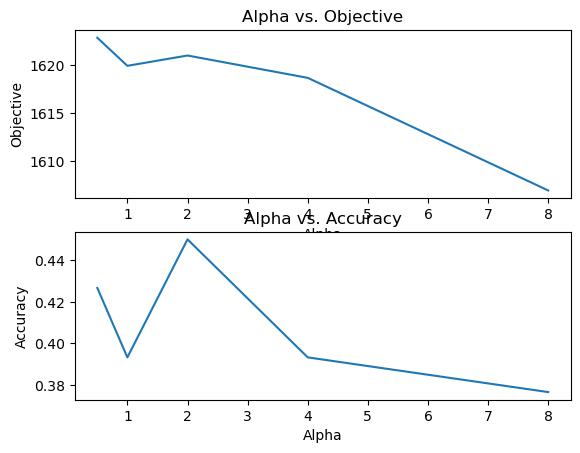

In [2]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, data, num_means):
        self.data = data
        self.num_means = num_means
        self.data_shape = data.shape[1]
        self.prior_probabilities = np.zeros(self.num_means)
        self.means = np.zeros((self.num_means, self.data_shape))
        self.covariance_matrices = []
        self.w = np.zeros((self.num_means, len(self.data)))
        self.labels = np.zeros(len(self.data))
        self.initialize()
        
    def initialize(self):
        #Set prior probabilities equal
        self.prior_probabilities = np.ones(self.num_means) * (1 / self.num_means)
        
        #Use same k-means++ strategy to initialize centers
        self.means[0] = data[np.random.randint(300)]
        for j in range(self.num_means-1):
            distances = np.zeros(len(self.data))
            for k in range(len(self.data)):
                distances[k] = calc_min_distance(self.data[k], self.means, 1 + j)[0]
            
            probabilities = distances / np.sum(distances)
            next_mean_idx = np.random.choice(len(distances), p=probabilities)
            self.means[j+1] = self.data[next_mean_idx]
            
        #Initialize covariance matrices to covariance of data
        for i in range(self.num_means):
            self.covariance_matrices.append(np.cov(self.data, rowvar=False))
        
    def train(self):
        convergence_reached = False
        while (not convergence_reached):
            #E-step: first compute w-values, then normalize by sum
            for i in range(self.w.shape[0]):
                for j in range(self.w.shape[1]):
                    self.w[i,j] = self.prior_probabilities[i] * multivariate_normal.pdf(data[j], mean=self.means[i], cov=self.covariance_matrices[i])
            sum_w_k = self.w.sum(axis=0)
            for i in range(self.w.shape[0]):
                for j in range(self.w.shape[1]):
                    self.w[i,j] = self.w[i,j] / sum_w_k[j]
            sum_w_i = self.w.sum(axis=1)   
            
            #M-step
            self.prior_probabilities = (1 / len(self.data)) * sum_w_i
            means_old = np.copy(self.means)
            self.means = np.matmul(self.w, self.data)
            for k in range(self.w.shape[0]):
                self.means[k] = self.means[k] / sum_w_i[k]
            if ((np.linalg.norm(means_old - self.means) / len(data)) < 10e-7):
                convergence_reached = True
            self.covariance_matrices = []
            for i in range(self.w.shape[0]):
                covariance_matrix = np.zeros((self.data_shape, self.data_shape))
                for j in range(self.w.shape[1]):
                    tmp = (data[j] - self.means[i])
                    covariance_matrix = covariance_matrix + (self.w[i,j] * np.outer(tmp, tmp))
                covariance_matrix = covariance_matrix / (sum_w_i[i])
                self.covariance_matrices.append(covariance_matrix)
        
    def calc_raw_labels(self):
        raw_labels = np.zeros(len(self.data))
        for i in range(len(self.data)):
            probabilities = np.zeros(self.num_means)
            for j in range(self.num_means):
                probabilities[j] = self.prior_probabilities[j] * multivariate_normal.pdf(data[i], mean=self.means[j], cov=self.covariance_matrices[j])
            raw_labels[i] = int(np.argmax(probabilities)+1)
        return raw_labels
        
    def calc_accuracy(self):
        raw_labels = self.calc_raw_labels()
        possible_mappings = [(1,2,3),(1,3,2),(2,1,3),(2,3,1),(3,1,2),(3,2,1)]
        possible_accuracies = np.zeros(6)
        
        for i in range(len(possible_mappings)):
            mapping = possible_mappings[i]
            accurate_count = 0
            for j in range(len(data)):
                label = raw_labels[j]
                if ((j < 100) and (label==mapping[0])):
                    accurate_count += 1
                if ((j >= 100) and (j < 200) and (label==mapping[1])):
                    accurate_count += 1
                if ((j >= 200) and (j < 300) and (label==mapping[2])):
                    accurate_count += 1
            possible_accuracies[i] = accurate_count / len(self.data)
        
        best_mapping_idx = np.argmax(possible_accuracies)
        best_mapping = possible_mappings[best_mapping_idx]
        self.accuracy = (possible_accuracies[best_mapping_idx])
        return self.accuracy
        
    def calc_objective(self):
        total = 0
        for i in range(len(self.data)):
            probability_sum = 0
            for j in range(self.num_means):
                probability_sum += self.prior_probabilities[j] * multivariate_normal.pdf(data[i], mean=self.means[j], cov=self.covariance_matrices[j])
            log_probability = math.log(probability_sum)
            total += log_probability
        
        self.objective = -1 * total
        return self.objective    
        
accuracy_list = []
objective_list = []

for i in range(len(data_list)):
    GMM_instance = GMM(data_list[i], 3)
    GMM_instance.train()
    accuracy_list.append(GMM_instance.calc_accuracy())
    objective_list.append(GMM_instance.calc_objective())

print(accuracy_list)
print(objective_list)

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(alpha_arr, objective_list)
ax1.set_title("Alpha vs. Objective")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Objective")
ax2.plot(alpha_arr, accuracy_list)
ax2.set_title("Alpha vs. Accuracy")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Accuracy")